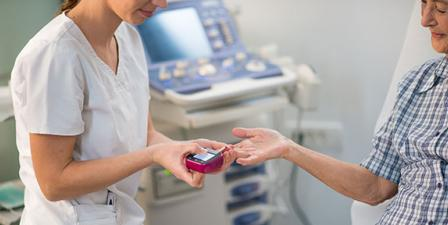

# Predicting Readmission of Diabetes Patients

In this project, we see if were are able to predict the readmittance of diabetes patients given data both about the patient and the treatment the patient received.

The dataset we use is _Diabetes 130-US hospitals for years 1999-2008_, available in the Public Domain through [UCI's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008#) and [Kaggle](https://www.kaggle.com/brandao/diabetes). This dataset was first created for the open access journal article by Strack et al. ["Impact of HbA1c Measurement on Hospital Readmission Rates"](https://www.hindawi.com/journals/bmri/2014/781670), itself a subset of the Health Facts Database curated by the Cerner Corporation. The creation of this 100,000+ record dataset was a query of diabetes diagnoses among 74,000,000 visitation records meeting certain criteria (such as length of stay being 24 hours or greater, or laboratory examinations being performed on the patients).

In [1]:
import pandas as pd
import data_prep as d
import functions as f
import warnings
warnings.filterwarnings('ignore')
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

## Data Cleaning

First, we download the features and the target datasets using d.clean(). This function isolates the target variables, removes unnecessary features, creates new features defined by diagnostic and administrative categories, and pre-processes the data for analysis.

In [2]:
X, y = d.clean()

Upload
y_clean
null_value_drop
reset_indices
column_drop
x_clean
values_lower
column_lowercase
categorize_all



diagnoses_1_3



diagnoses_2_3



diagnoses_3_3



number_meds



num_down



num_up



X_dummy_variables
outliers_bin



outliers_log


To ensure that the data has been properly downloaded, we will preview the datasets. In addition, we will look at the distribution of the target values.

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68130 entries, 0 to 68129
Data columns (total 72 columns):
female                    68130 non-null int64
age                       68130 non-null int64
num_procedures            68130 non-null int64
number_diagnoses          68130 non-null int64
max_glu_serum             68130 non-null int64
a1cresult                 68130 non-null int64
change                    68130 non-null int64
diabetesmed               68130 non-null int64
icd_1                     68130 non-null int64
icd_2                     68130 non-null int64
icd_3                     68130 non-null int64
icd_4                     68130 non-null int64
icd_5                     68130 non-null int64
icd_6                     68130 non-null int64
icd_7                     68130 non-null int64
icd_8                     68130 non-null int64
icd_9                     68130 non-null int64
icd_10                    68130 non-null int64
icd_11                    68130 non-null int6

In [4]:
y.value_counts()

0    40168
1    27962
Name: readmitted, dtype: int64

We can see that the data is ready for usage. We can also see that the target value is imbalanced, but since it is not excessively imbalanced, we will not upsample or downsample.

## Models

### Baseline model — Dummy Classifier

Prior to implementing our baseline model, we split the data into a 75% training set and a 25% test set in preparation for the initial model. Since the target is imbalanced, this function will also stratify the test data to ensure target value proportionality. This function will also standardize all the features along a [0:1] axis.

In [5]:
X_train, X_test, y_train, y_test = f.standardize_train_test_split(X, y)

Our baseline model is a dummy classifier that automatically classifies each patient as "not returning". This function will create this model, and construct a classification matrix. Since failing to determine a patient that will need additional care is more potentially destructive than falsely classifying a patient as needing care, we will be using the Recall score to judge model effectiveness. For comparison's sake, we will also include the accuracy and the F1 score.

This function will also return a dictionary that we will update with each model's recall score.

Recall score:  0.0
Test Accuracy score:  0.589561439558504
Test F1 score:  0.0


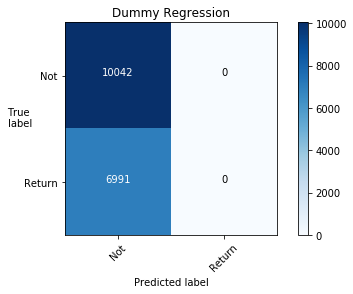

In [6]:
r_dict = f.dummy_regression(X_train, X_test, y_train, y_test)

We will use this dummy regression as our baseline.

----

### Model #1 ⁠— Logistic Regression
We will now determine the performance of a logistic regression. The following function will perform a grid search to determine which parameters optimize recall. It will then create a logistic regression model using these parameters, and return the recall and F1 scores. Finally, we will graph the model's performance. Since the targets are imbalanced, we will use a precision-recall curve instead of an ROC curve. The curve will include a 'no-skill' line defined by the ratio of the 'return' class to the 'no return' class.

Best Parameter Combination Found During Grid Search:
{'C': 5, 'fit_intercept': False, 'penalty': 'l2', 'tol': 0.0002, 'warm_start': True}
Recall score:  0.28322128450865397
Test Accuracy score:  0.6207362179299007
Test F1 score:  0.3800383877159309


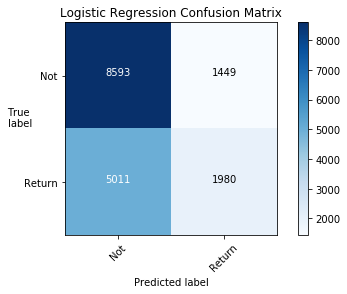

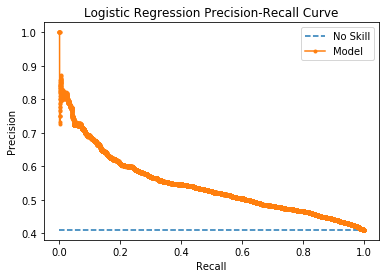

AUC: 0.544279155473385


In [7]:
r_dict = f.log_gridsearch(X_train, y_train, X_test, y_test, r_dict)

We can see that this model shows a better recall score than the dummy classifier (in addition to improved accuracy and F1 scores). From this point on, we will compare model performance, including precision-recall curve area under curve (AUC), to the logistic regression model.

### Model #2 ⁠— Random Forests

Next, we will build and test a random forests model with bootstrapping to prevent overfitting.

In order to prevent training/test leakage, we will create new training and test datasets for each of our models.

In [9]:
X_train, X_test, y_train, y_test = f.standardize_train_test_split(X, y, r_s=43)

The next function will perform a grid search to determine the best parameters for the random forests models and create the model. It will then return the scores, confusion matrix, and precision-recall curve. 

Best Parameter Combination Found During Grid Search:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'warm_start': True}
Recall score:  0.3779144614504363
Test Accuracy score:  0.5980156167439676
Test F1 score:  0.4355782705465337


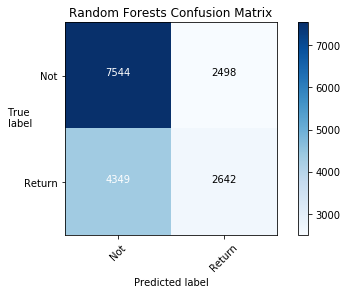

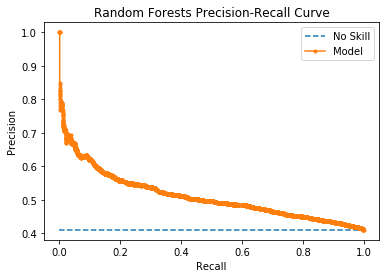

AUC: 0.5116439039021635


In [10]:
r_dict = f.forests_gridsearch(X_train, y_train, X_test, y_test, r_dict)

We can see that although the logistic regression model outperforms the random forests model in accuracy and in the precision-recall curve AUC, it provides an improved recall score (in addition to the improved F1 score). Based on this, the random forests model is (for our purposes) superior to the logistic regression model. Next, we will use boosting on both the logistic and random forests models.

----

### Model #3 ⁠— AdaBoost

We will now create an AdaBoost logistic regression in order to determine whether boosting improves upon our logistic regression. We will create a new train/test split, perform a grid-search to determine the optimal parameters, and create a model. We will then return the model's scores, confusion matrix, and precision-recall curve for the subsequent model.

In [11]:
X_train, X_test, y_train, y_test = f.standardize_train_test_split(X, y, r_s=44)

Best Parameter Combination Found During Grid Search:
{'learning_rate': 1.4, 'n_estimators': 50}
Recall score:  0.2973823487340867
Test Accuracy score:  0.6251981447777843
Test F1 score:  0.39442231075697215


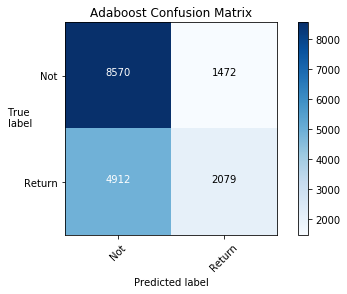

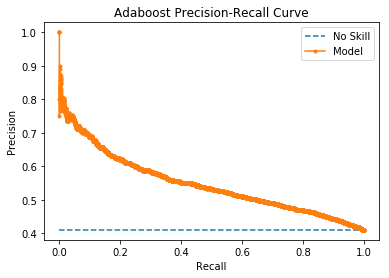

AUC: 0.5483152368438259


In [12]:
r_dict = f.adaboost_gridsearch(X_train, y_train, X_test, y_test, r_dict)

Although this marks an improvement in each scoring metric over the logistic regression, it still provides a worse recall score (and F1 score) than the random forests model. Next we will use a gradient boosting classifier to try to improve upon the random forests model.

### Model #4 ⁠— Gradient Boosting Classifier

We will now create an gradient boosting classifier in order to determine whether boosting improves upon our random forests model. We will create a new train/test split, perform a grid-search to determine the optimal parameters, and create a model. We will then return the model's scores, confusion matrix, and precision-recall curve for the subsequent model.

In [13]:
X_train, X_test, y_train, y_test = f.standardize_train_test_split(X, y, r_s=45)

Best Parameter Combination Found During Grid Search:
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100, 'warm_start': True}
Recall score:  0.18337862966671434
Test Accuracy score:  0.6179768684318675
Test F1 score:  0.28265902326094144


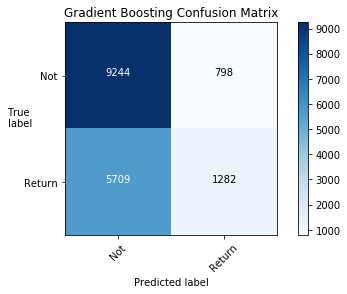

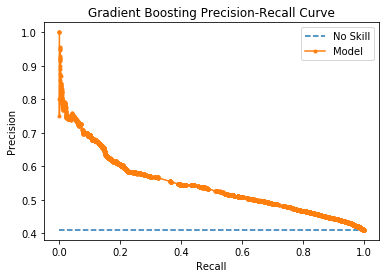

AUC: 0.5454225152893211


In [14]:
r_dict = f.gboost_gridsearch(X_train, y_train, X_test, y_test, r_dict)

As you can see, the recall score is significantly lower than prior models, along with lower F1 scores. This is despite the fact that accuracy and AUC scores are similar to prior models.

We will now create a graph comparing the recall scores for each model.

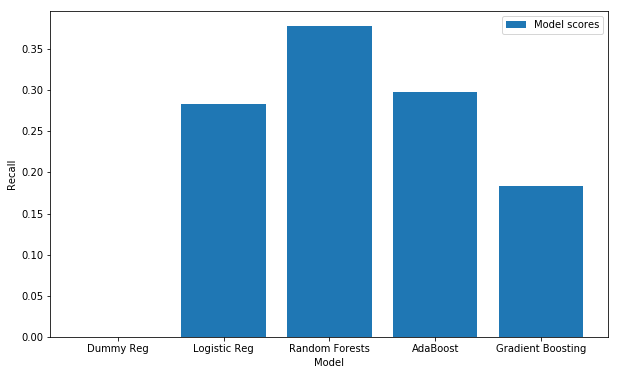

In [15]:
f.recall_compare(r_dict)

As we can see, the Random Forests model outperforms the other models in terms of recall.

----

## Conclusion

Based on these calculations, we can determine that the random forests model performs the best using the recall score as the primary grading metric. This is despite the fact that the AdaBoost model outperforms using Accuracy, F1 score, and AUC. However, while these metrics outperform the dummy logistical regression baseline, the recall scores are still relatively low, indicating that the features are less-than-sufficient to accurately predict whether a patient will be returning to the hospital.

In addition, since the dataset cannot specify whether the non-returning patients do not return due to a lack of health problems, or whether they are not returning due to other problems (ex. sudden death, inability to pay, etc.), a non-returning status should not be mistaken for a lack of medical need.